In [1]:
import numpy as np
import pandas as pd
import scipy.io as sio
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit
import pdb
from Patch_ana import patch_pip
import seaborn as sns

% matplotlib inline
%load_ext autoreload
% autoreload

In [2]:
cd /data/

/data


In [4]:
asso2 = pd.read_pickle('ana_am_asso')
asso50 = pd.read_pickle('ana_am_asso_50')

In [5]:
asso50

,Before,After,elimi
2018021301,"{'ir': [[96.0958708487], [99.2656212909], [93....","{'ir': [[94.0285207032], [102.011585328], [102...",24
2018021302,"{'ir': [[131.431247219], [132.826175038], [127...","{'ir': [[123.322818236], [125.008107294], [121...",28
2018021303,"{'ir': [[127.914725338], [132.117463293], [131...","{'ir': [[109.23195848], [104.961264577], [102....",24
2018022801,"{'ir': [[77.5483087882], [75.121058642], [71.2...","{'ir': [[63.4086486848], [59.1023257703], [58....",30
2018022802,"{'ir': [[95.0471695024], [95.4370889978], [91....","{'ir': [[92.3311499794], [89.4725235493], [90....",27
2018030101,"{'ir': [[111.862696979], [100.149345302], [97....","{'ir': [[89.1891852991], [91.8540489559], [92....",24


/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:26: RuntimeWarning: Mean of empty slice
/usr/local/lib/python3.5/dist-packages/numpy/lib/nanfunctions.py:1423: RuntimeWarning: Degrees of freedom <= 0 for slice.
  keepdims=keepdims)
/usr/local/lib/python3.5/dist-packages/ipykernel/__main__.py:53: RuntimeWarning: Mean of empty slice


[0, 60, 0.1, 3]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


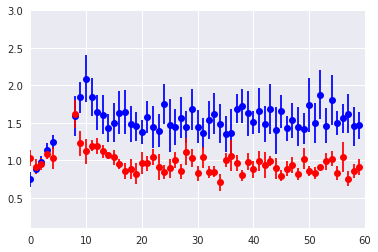

In [12]:
data = asso2
ave_ptl_resp = np.ones((len(data), 60))*np.nan

for i in range(len(data)):
    bef_resp = data.iloc[i]['Before']['ave_amp1'][-5:]
    bef_rs = np.nanmean(data.iloc[i]['Before']['rs'][-5:])
    aft_rs = np.nanmean(data.iloc[i]['After']['rs'][:(data.iloc[i]['elimi']-7)][-5:])
    aft_resp = data.iloc[i]['After']['ave_amp1'][:(data.iloc[i]['elimi']-7)]*aft_rs/bef_rs
    bef_mean = np.nanmean(bef_resp)
    if aft_resp.shape[0] < 52:
        length_fill = 52 - aft_resp.shape[0]
        mean_fill = np.nanmean(aft_resp[-5:])
        ste_fill =  np.nanstd(aft_resp[-5:])
        np.random.seed(i)
        aft_fill = np.random.normal(loc=mean_fill, scale=ste_fill, size=(1,length_fill))  
        aft_resp = np.concatenate((aft_resp, aft_fill.reshape(-1,1)))
    
    bef_resp = bef_resp/bef_mean
    aft_resp = aft_resp/bef_mean
    resp1_joint= np.concatenate([bef_resp, np.ones((3,1))*np.nan, aft_resp])
    ave_ptl_resp[i,:5] = bef_resp.reshape(1,-1)
    ave_ptl_resp[i,8:] = aft_resp[-52:].reshape(1,-1)
#   plt.figure()
#   plt.plot(resp1_joint, 'o', label='Resp 1')

ave_ptl_mean_2 = np.nanmean(ave_ptl_resp, axis=0)
ave_ptl_ste_2 = np.nanstd(ave_ptl_resp, axis=0)/np.sqrt(i)
plt.errorbar(x=np.arange(len(ave_ptl_mean_2)), y=ave_ptl_mean_2, yerr=ave_ptl_ste_2, fmt='bo')

data = asso50
ave_ptl_resp = np.ones((len(data), 60))*np.nan

for i in range(len(data)):
    bef_resp = data.iloc[i]['Before']['ave_amp1'][-5:]
    bef_rs = np.nanmean(data.iloc[i]['Before']['rs'][-5:])
    aft_rs = np.nanmean(data.iloc[i]['After']['rs'][:(data.iloc[i]['elimi']-7)][-5:])
    aft_resp = data.iloc[i]['After']['ave_amp1'][:(data.iloc[i]['elimi']-7)]*aft_rs/bef_rs
    bef_mean = np.nanmean(bef_resp)
    if aft_resp.shape[0] < 52:
        length_fill = 52 - aft_resp.shape[0]
        mean_fill = np.nanmean(aft_resp[-5:])
        ste_fill =  np.nanstd(aft_resp[-5:])
        np.random.seed(i)
        aft_fill = np.random.normal(loc=mean_fill, scale=ste_fill, size=(1,length_fill))  
        aft_resp = np.concatenate((aft_resp, aft_fill.reshape(-1,1)))
    
    bef_resp = bef_resp/bef_mean
    aft_resp = aft_resp/bef_mean
    resp1_joint= np.concatenate([bef_resp, np.ones((3,1))*np.nan, aft_resp])
    ave_ptl_resp[i,:5] = bef_resp.reshape(1,-1)
    ave_ptl_resp[i,8:] = aft_resp[-52:].reshape(1,-1)
    
ave_ptl_mean_50 = np.nanmean(ave_ptl_resp, axis=0)
ave_ptl_ste_50 = np.nanstd(ave_ptl_resp, axis=0)/np.sqrt(i)
plt.errorbar(x=np.arange(len(ave_ptl_mean_50)), y=ave_ptl_mean_50, yerr=ave_ptl_ste_50, fmt='ro')
plt.axis([0,60,0.1,3])

In [7]:
# Perform processing on before amplitude
def pro_bef(data_mean, data_ste):
    for i in range(len(data_mean)):
        if data_mean[i]+data_ste[i]<1:
            data_mean[i] = 1 - 0.1*data_ste[i]
        elif data_mean[i]-data_ste[i]>1:
            data_mean[i] = 1 + 0.1*data_ste[i]
            
    return data_mean, data_ste

[0, 60, 0.1, 3]

/usr/local/lib/python3.5/dist-packages/matplotlib/font_manager.py:1297: UserWarning: findfont: Font family ['sans-serif'] not found. Falling back to DejaVu Sans
  (prop.get_family(), self.defaultFamily[fontext]))


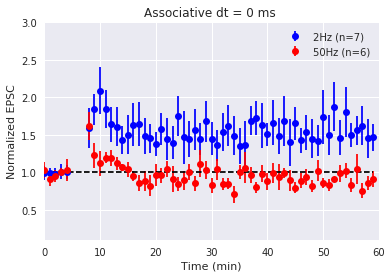

In [11]:
ave_ptl_mean_2cp, ave_ptl_ste_2cp =  ave_ptl_mean_2, ave_ptl_ste_2
ave_ptl_mean, ave_ptl_ste = pro_bef(ave_ptl_mean_2cp[:5], ave_ptl_ste_2cp[:5])
ave_ptl_mean_2cp[:5], ave_ptl_ste_2cp[:5] = ave_ptl_mean, ave_ptl_ste 
plt.errorbar(x=np.arange(len(ave_ptl_mean_2cp)), y=ave_ptl_mean_2cp, yerr=ave_ptl_ste_2cp, fmt='bo', label='2Hz (n={a})'.format(a=len(asso2)))
ave_ptl_mean_50cp, ave_ptl_ste_50cp =  ave_ptl_mean_50, ave_ptl_ste_50
ave_ptl_mean, ave_ptl_ste = pro_bef(ave_ptl_mean_50cp[:5], ave_ptl_ste_50cp[:5])
ave_ptl_mean_50cp[:5], ave_ptl_ste_50cp[:5] = ave_ptl_mean, ave_ptl_ste 
plt.errorbar(x=np.arange(len(ave_ptl_mean_2cp)), y=ave_ptl_mean_50cp, yerr=ave_ptl_ste_50cp, fmt='ro', label='50Hz (n={a})'.format(a=len(asso50)))
plt.plot(np.ones((60))*1, 'k--')
plt.xlabel('Time (min)')
plt.ylabel('Normalized EPSC')
plt.legend()
plt.title('Associative dt = 0 ms ')
plt.axis([0,60,0.1,3])